### Load packages

In [175]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import fnmatch
import csv
import pickle
import warnings
import sklearn.preprocessing
warnings.filterwarnings('ignore')


### Required for building NN ###
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense
import tensorflow.keras.backend as K

### Import and plot ZLP data

Note: every time this generates a random seed to make sure training data the training sample is different.


 ************************ Data files have been prepared ***************************** 

Seed number for this set is: 69

 ****************** Training and validation sets have been prepared **************** 

 prepare_single_data 
 prepare_semisingle_data 
 prepare_mixed_data


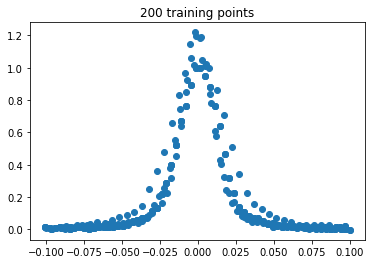

In [176]:
%run EELS-ZLP.py

### Find uncertainties on training data

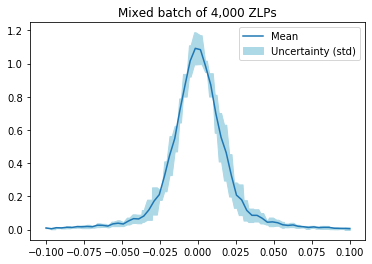

In [177]:
%run Functions.ipynb

nbins = 60
x_train, y_train, x_val, y_val = prepare_mix_data()

# Create a plot of the mean & std 
plot_uncertainties()


### Store output vectors

In [178]:
# Store output vectores
df_train, cuts1, cuts2 = ewd()
mean, std, count= binned_statistics()
variance_vector = vectorize_variance()
mean_vector = vectorize_mean()

#create one vector with (x_train, y_train, sigma_train)
df_train = np.c_[df_train, variance_vector]

## Neural Network

### Create architecture

In [179]:
def make_model():
    model = tf.keras.Sequential()
    model.add(Dense(5, activation='relu', input_shape=(1,)))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(1, activation='linear'))
    #keras.layers.Dropout(0.20, noise_shape=None, seed=None)
    return model




## Training

In [182]:
mode = 'Mixture'
epoch_size = 15
batch_size = 3000
training_size = len(df_train[:,0])
print("Total number of samples to be trained on:", training_size)

K.clear_session()

  
if mode == 'Mixture':
    print ("********** Prepare training on mixed ZLP spectra... **********")
    x_train = df_train[:,0]
    y_train = df_train[:,1]
    sigma = df_train[:,2]
    
    sgd = keras.optimizers.SGD(lr=1e-4)
    
    adam = keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False)

    model = make_model()
    model.compile(loss='mse',
                  optimizer=adam,
                  metrics=[custom_cost])
    model.summary()
    
    loss = model.fit(x_train, y_train, batch_size = batch_size, epochs=epoch_size, verbose=1)
    
    print("********** Training completed! **********")
    
else:
    print("No mode specified. Training not possible.")
    
    


Total number of samples to be trained on: 40000
********** Prepare training on mixed ZLP spectra... **********
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5)                 10        
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 76
Trainable params: 76
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
40000/40000 [==============================] - 3s 76us/sample - loss: 0.1122 - custom_cost: 2734.1125
Epoch 2/15
40000/40000 [==============================

### Store data

In [183]:
hist_df = pd.DataFrame(loss.history) 
#save to csv: 
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)
    
loss_data = pd.read_csv('history.csv')['loss']
chi_data = pd.read_csv('history.csv')['custom_cost']
#val_loss_data = pd.read_csv('history.csv')['val_loss']
#val_chi_data = pd.read_csv('history.csv')['val_custom_cost']
#mse_data = pd.read_csv('history.csv')['mean_squared_error']
#val_mse_data = pd.read_csv('history.csv')['val_mean_squared_error']
#std = pd.read_csv('history.csv')['std']

### Plot outputs

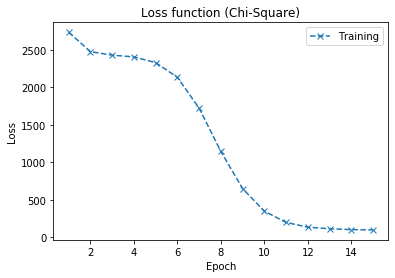

In [184]:
plt.figure()
plt.plot(np.linspace(1,epoch_size,epoch_size), chi_data,'x--', label='Training')
#plt.plot(np.linspace(1,epochsize,epochsize), val_loss_data,'x--', label='Validation')
#plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss function (Chi-Square)')
#plt.ylim([0,10])
plt.savefig('Figures/Mixed-samples')
plt.show()


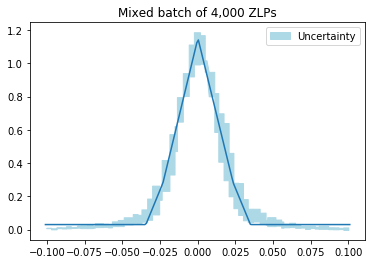

[0.09535118]


In [186]:
xnew = np.linspace(-0.101, 0.101, 200)
ynew = model.predict(xnew)
var = ynew.var(axis=0)

plt.plot(xnew, ynew)
plt.fill_between(df_train[:,0], upper_limit, lower_limit, color='lightblue', label='Uncertainty')
plt.legend()
plt.title('Mixed batch of 4,000 ZLPs')
plt.show()
print(var)